In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from matplotlib import rcParams, pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
import warnings 
warnings.filterwarnings(action='ignore')

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print('No GPU detected')


1 Physical GPUs, 1 Logical GPU


In [5]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [6]:
data_dir = Path('/content/drive/MyDrive/dacon/input')
feature_dir = Path('../build/feature')
val_dir = Path('/content/drive/MyDrive/dacon/build/val')
tst_dir = Path('/content/drive/MyDrive/dacon/build/tst')
sub_dir = Path('/content/drive/MyDrive/dacon/build/sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test_x.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'author'
n_fold = 5
n_class = 5
seed = 42

In [7]:
algo_name = 'cnn'
feature_name = 'emb'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [333]:
train = pd.read_csv(trn_file, index_col=0)
train.head()

,text,author
index,,
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [334]:
test = pd.read_csv(tst_file, index_col=0)
test.head()

,text
index,
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


In [148]:
train[train['text'].str.contains("\"")]

,text,author
index,,
5,"""It was well fought,"" he said, ""and, by my soo...",4
30,"""I won't give up odin to you,"" he said. odin s...",3
41,"""Well, it is a translation.""",2
42,"""Perhaps you are not aware,"" said he, ""that I ...",2
59,"""You have heard, Mr. Jackson, of the urim and ...",2
...,...,...
54840,"""Ye hurt me,"" sobbed odin. ""Ye hurt me when ye...",4
54845,"""Then it is settled,"" said Lord odin, and turn...",2
54856,"""Is that you, odin Yegorytch?"" asked odin.",3


In [335]:
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()

In [336]:
train['text'] = train['text'].str.replace('\?',' quesmark ')
train['text'] = train['text'].str.replace('\!',' exclmark ')
train['text'] = train['text'].str.replace('\&',' empent ')
train['text'] = train['text'].str.replace("\*",' chstar ')
train['text'] = train['text'].str.replace(";",' smcolons  ')

test['text'] = test['text'].str.replace('\?',' quesmark ')
test['text'] = test['text'].str.replace('\!',' exclmark ')
test['text'] = test['text'].str.replace('\&',' empent ')
test['text'] = test['text'].str.replace("\*",' chstar ')
test['text'] = test['text'].str.replace(";",' smcolons  ')

In [337]:
from collections import Counter
cnt = Counter()
for text in train["text"].values:
    for word in text.split():
        cnt[word] += 1
        

In [338]:
n_rare_words = 40
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

train["text"] = train["text"].str.lower().apply(remove_rarewords)

In [339]:
train['text']=train['text'].str.replace('á', ' Ascenda ')
train['text']=train['text'].str.replace('à', ' Descenda ')
train['text']=train['text'].str.replace('â', ' Stremama ')
train['text']=train['text'].str.replace('ä', ' Doublea ')
train['text']=train['text'].str.replace('é', ' Ascende ')
train['text']=train['text'].str.replace('í', ' Justi ')
train['text']=train['text'].str.replace('ï', ' Doublei ')
train['text']=train['text'].str.replace('ó', ' Comao ')
train['text']=train['text'].str.replace('ú', ' Ascendu ')
train['text']=train['text'].str.replace('ý', ' Ascendy ')
train['text']=train['text'].str.replace('ü', ' Umlaut ')
train['text']=train['text'].str.replace('è', ' Descende ')
train['text']=train['text'].str.replace('£', ' Maludf ')

test['text']=test['text'].str.replace('ä', ' Doublea ')
test['text']=test['text'].str.replace('â', ' Stremama ')
test['text']=test['text'].str.replace('à', ' Descenda ')
test['text']=test['text'].str.replace('á', ' Ascenda ')
test['text']=test['text'].str.replace('é', ' Ascende ')
test['text']=test['text'].str.replace('ï', ' Doublei ')
test['text']=test['text'].str.replace('í', ' Justi ')
test['text']=test['text'].str.replace('ó', ' Comao  ')
test['text']=test['text'].str.replace('ú', ' Ascendu ')
test['text']=test['text'].str.replace('ý', ' Ascendy ')
test['text']=test['text'].str.replace('ü', ' Umalut ')
test['text']=test['text'].str.replace('è', ' Descende ')
test['text']=test['text'].str.replace('£', ' Maludf ')

In [340]:
train['text']=train['text'].str.replace('\(', ' \( ')
train['text']=train['text'].str.replace('\{', ' \{ ')
train['text']=train['text'].str.replace('\[', ' \[ ')
train['text']=train['text'].str.replace('\)', ' \) ')
train['text']=train['text'].str.replace('\}', ' \} ')
train['text']=train['text'].str.replace('\]', ' \] ')
train['text']=train['text'].str.replace('—', '')
train['text']=train['text'].str.replace('_', '')
train['text']=train['text'].str.replace(':', '')


test['text']=test['text'].str.replace('\(', ' \( ')
test['text']=test['text'].str.replace('\{', ' \{ ')
test['text']=test['text'].str.replace('\[', ' \[ ')
test['text']=test['text'].str.replace('\)', ' \) ')
test['text']=test['text'].str.replace('\}', ' \} ')
test['text']=test['text'].str.replace('\]', ' \] ')
test['text']=test['text'].str.replace('—', '')
test['text']=test['text'].str.replace('_', '')
test['text']=test['text'].str.replace(':', '')

In [341]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [342]:
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer

def lemma_text(text):
    tokenizer=TweetTokenizer()
    words=tokenizer.tokenize(text)
    lem = WordNetLemmatizer()
    words=[lem.lemmatize(word, "v") for word in words]
    
    clean_sent=" ".join(words)
    
    return clean_sent

train['text'] = train['text'].str.lower().apply(lemma_text)
test['text'] = test['text'].str.lower().apply(lemma_text)

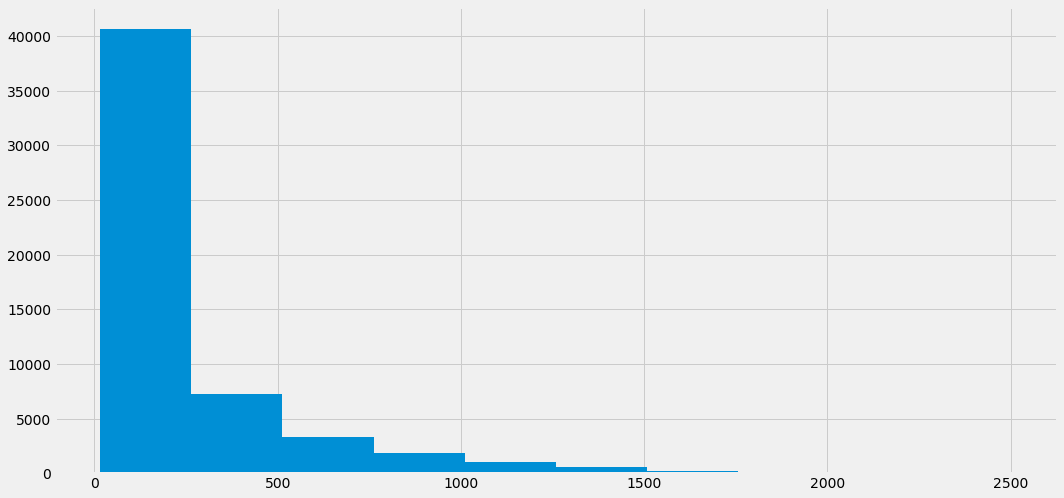

In [159]:
train['text'].str.len().hist()

In [343]:
X_trn = train['text'].values
X_tst = test['text'].values
y = train['author'].values
print(X_trn.shape, X_tst.shape, y.shape)

(54879,) (19617,) (54879,)


In [344]:
vocab_size = 21000
embedding_dim = 128
max_length = 520
padding_type='post'

In [345]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_trn)
word_index = tokenizer.word_index

In [346]:

train_sequences = tokenizer.texts_to_sequences(X_trn)
test_sequences = tokenizer.texts_to_sequences(X_tst)

In [347]:
trn = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)
tst = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)
print(trn.shape, tst.shape)

(54879, 520) (19617, 520)


In [348]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [349]:
def get_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Dropout(0.2),
        Conv1D(256, 3, padding='valid', activation='relu', strides=1),  
        GlobalMaxPooling1D(), 
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(n_class, activation='softmax')
    ])
    
    # compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=.005))
    return model

In [350]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    clf = get_model()    
    clf.fit(trn[i_trn], 
            to_categorical(y[i_trn]),
            validation_data=(trn[i_val], to_categorical(y[i_val])),
            epochs=10,
            batch_size=256,
            callbacks=[es])
    p_val[i_val, :] = clf.predict(trn[i_val])
    p_tst += clf.predict(tst) / n_fold

training model for CV #1
Epoch 1/10
172/172 [==============================] - 16s 91ms/step - loss: 0.9764 - val_loss: 0.6700
Epoch 2/10
172/172 [==============================] - 15s 89ms/step - loss: 0.5714 - val_loss: 0.5993
Epoch 3/10
172/172 [==============================] - 15s 89ms/step - loss: 0.4124 - val_loss: 0.6280
Epoch 4/10
172/172 [==============================] - 15s 89ms/step - loss: 0.3230 - val_loss: 0.6438
Epoch 5/10
172/172 [==============================] - 15s 89ms/step - loss: 0.2701 - val_loss: 0.7145
Epoch 00005: early stopping
training model for CV #2
Epoch 1/10
172/172 [==============================] - 16s 93ms/step - loss: 0.9977 - val_loss: 0.6688
Epoch 2/10
172/172 [==============================] - 15s 90ms/step - loss: 0.5884 - val_loss: 0.6128
Epoch 3/10
172/172 [==============================] - 15s 89ms/step - loss: 0.4295 - val_loss: 0.6471
Epoch 4/10
172/172 [==============================] - 15s 89ms/step - loss: 0.3447 - val_loss: 0.6743
Epoc

In [352]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p_val):8.4f}')


Accuracy (CV):  78.9592%
Log Loss (CV):   0.5891


In [353]:

np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

In [354]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(19617, 5)


,0,1,2,3,4
index,,,,,
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [355]:
sub[sub.columns] = p_tst
sub.head()

,0,1,2,3,4
index,,,,,
0,0.0150,0.2546,0.6799,0.0500,0.0005
1,0.1403,0.3007,0.0803,0.3039,0.1747
2,0.9796,0.0122,0.0051,0.0024,0.0006
3,0.0522,0.0201,0.8619,0.0330,0.0328
4,0.5866,0.0088,0.2186,0.0844,0.1016


In [356]:
sub.to_csv(sub_file)